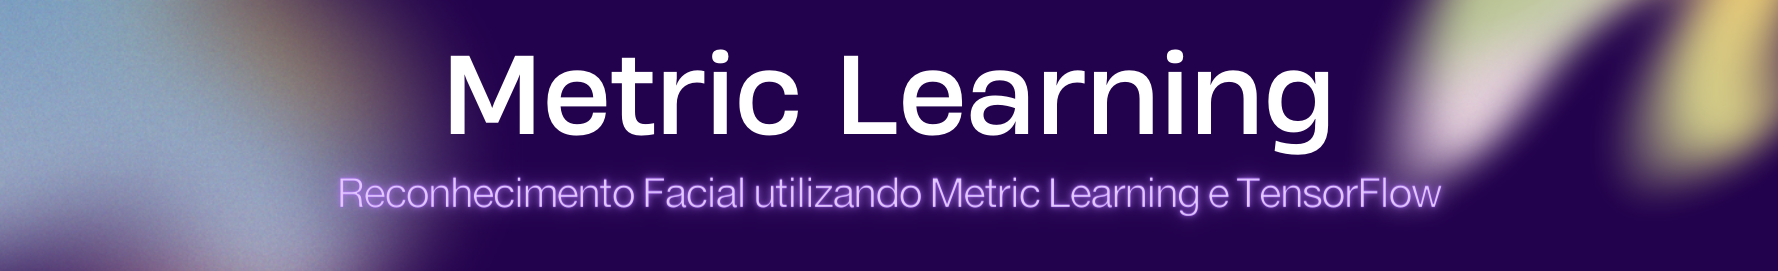



Este experimento tem como objetivo implementar um modelo de reconhecimento facial utilizando aprendizado de métrica e TensorFlow. O experimento usa um conjunto de dados de rostos de famosos para treinar o modelo e comparar as características do rosto com as do banco de dados. O experimento também inclui a adição de novos rostos ao banco de dados e testando uma outra foto desse último rosto usando máscara facial, para verificar a eficiência da técnica.

## Entendendo Metric Learning

Modelos de Reconhecimento Facial são importantes para a humanidade do século XXI. Diversos projetos de Machine Learning existem e funcionam "*muito bem, obrigado!*"

Porém, quando surge novas pessoas para serem adicionadas no banco de dados, era necessário re-treinar os modelos para cada nova classe. Para ajudar nesse processo, o Metric Learning foi desenvolvido. Essa técnica usa modelos para aprender uma métrica de distância entre duas entidades, fornecendo vetores descritores para computar as características faciais de uma pessoa.


Metric Learning é uma abordagem baseada diretamente em uma métrica de distância que visa estabelecer a similaridade ou dissimilaridade entre imagens. Deep Metric Learning, por outro lado, usa Redes Neurais para aprender automaticamente características discriminativas das imagens e, em seguida, computar a métrica.

###Qual a necessidade de usar essa técnica?

- Faces da mesma pessoa quando apresentadas em diferentes poses, expressões, iluminações, etc. podem enganar facilmente um sistema de verificação/reconhecimento de faces.
- A tarefa de construir um sistema eficiente e de grande escala de Verificação de Faces é radicalmente uma tarefa de projetar funções de perda apropriadas que melhor discriminem as classes em estudo. Nos últimos anos, o aprendizado de métrica/distância usando Deep Learning mostrou resultados altamente satisfatórios para muitas tarefas de visão computacional, como reconhecimento de faces, verificação de faces, classificação de imagens, detecção de anomalias, etc.
- Metric Learning tem uma capacidade limitada de capturar não linearidade nos dados.

> Deep Metric Learning ajuda a capturar estrutura de características não lineares, aprendendo uma transformação não linear do espaço de características.
> Saiba mais neste [artigo do Medium](https://towardsdatascience.com/the-why-and-the-how-of-deep-metric-learning-e70e16e199c0).


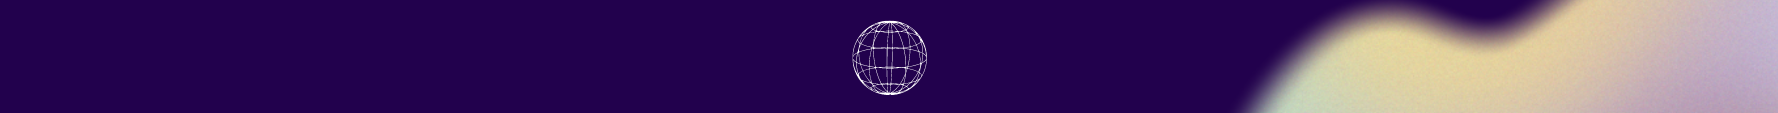

##Preparando o dataset

In [ ]:
# Download do dataset
!wget https://github.com/LuanMagioli/Machine-Learning/raw/main/Metric%20Learning/input/post-processed.zip
!unzip -qq post-processed.zip -d /content/post-processed/

# Download das imagens de teste
!wget https://github.com/LuanMagioli/Machine-Learning/raw/main/Metric%20Learning/input/person.jpg
!wget https://github.com/LuanMagioli/Machine-Learning/raw/main/Metric%20Learning/input/person_mask.jpg

Para este exemplo usaremos o tensorflow, uma biblioteca de aprendizado de máquina que fornece uma ampla gama de ferramentas para criar, treinar e avaliar modelos de aprendizado de máquina. 

As imagens do dataset serão carregadas utilizando a ferramenta de pre-processamento do Keras que lista todos os arquivos da pasta  e os carrega automaticamente, de forma que seja possível realizar o treinamento dos modelos. Os dados serão convertidos em matrizes de números para que o modelo possa processá-los, além de serem transformados para serem normalizados, o que permite obter melhores resultados na classificação.

In [5]:
import tensorflow as tf
from tensorflow import keras

# Carregando o dataset de imagens
data_dir = "post-processed/"

data_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

# Separando os dados entre treino e teste
train_dataset = data_gen.flow_from_directory(batch_size=32,
                                                 directory=data_dir,
                                                 shuffle=True,
                                                 target_size=(112, 112), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = data_gen.flow_from_directory(batch_size=32,
                                                 directory=data_dir,
                                                 shuffle=True,
                                                 target_size=(112, 112), 
                                                 subset="validation",
                                                 class_mode='categorical')

Found 10005 images belonging to 2996 classes.
Found 1995 images belonging to 2996 classes.


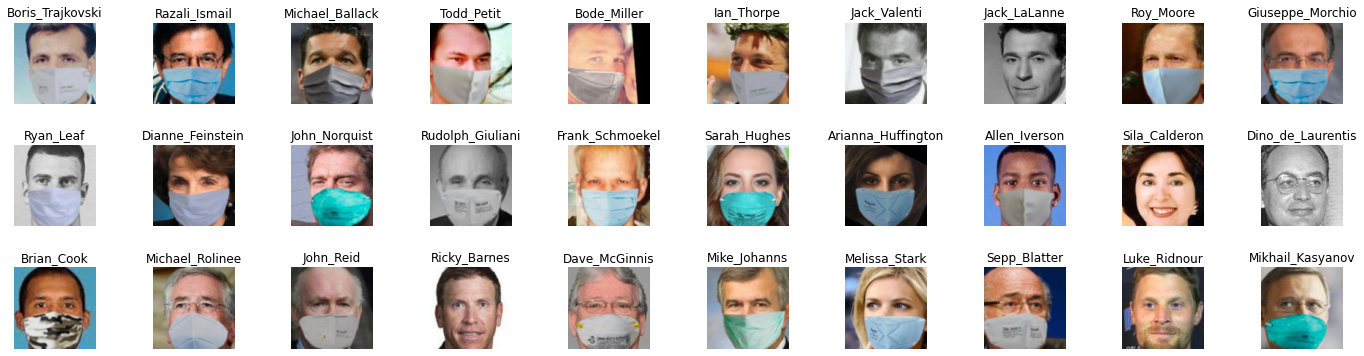

In [6]:
import matplotlib.pyplot as plt
import numpy as np

x, y = train_dataset.next()

# Pegando umas imagens aleatórias do Dataset
random_indices = np.random.choice(np.arange(x.shape[0]), size=30, replace=False)
random_images = x[random_indices]

# Guardando o nome das pessoas dos exemplos
class_names = sorted(train_dataset.class_indices)
random_labels = [class_names[np.argmax(y[index])] for index in random_indices]

# Exibindo as imagens num grid 4x10 
fig, axes = plt.subplots(3, 10, figsize=(24, 6))
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(random_images[i])
    ax.axis('off')
    ax.set_title(random_labels[i])
plt.subplots_adjust(wspace=0.5, hspace=0.5  )
plt.show()


##Configurando o modelo

Essa é uma abordagem geral para criar um modelo de aprendizado de métrica. O modelo base é treinado para reconhecimento das características, e a camada de saída adicional é treinada para produzir vetor de características.

Para computar o Loss é necessário implementar a função triplet_loss() (Perda triangular) que é uma implementação comum usada para modelos de aprendizado de métrica. Existem diversas versões desta função e recomendo dar uma olhada pela internet, mas abaixo já fiz uma das mais simples para a gente trabalhar neste exemplo.

### Função Triplet Loss

É baseada em várias publicações científicas que abordam esse tema, como o artigo "FaceNet: A Unified Embedding for Face Recognition and Clustering" de Schroff et al. publicado em 2015. Esse artigo apresenta a utilização da *triplet loss* para gerar características de rostos que podem ser usadas para o nosso caso.

A função é utilizada para garantir que características de imagens de uma mesma classe são mais semelhantes entre si do que características de imagens de outras classes. A ideia é que se a distância entre uma imagem ancora e outra imagem positiva (de mesma classe) é menor do que a distância entre a imagem ancora e uma imagem negativa (de outra classe) com uma margem Alpha, é uma forma de garantir que o modelo esteja aprendendo características distintivas para cada classe.

Esse tipo de função de perda é comumente utilizada em sistemas de reconhecimento de imagem, inclusive existem algumas implementações já prontas para serem usadas, como a presente em algumas bibliotecas de deep learning como o Keras-metrics, mas a implementação específica que forneci, foi feita por mim com base nas referências mencionadas.

In [8]:
from tensorflow.keras import backend as K

def triplet_loss(y_true, y_pred, alpha = 0.3):
    """
    Calcular a triplet loss
    :param y_true: verdadeiros rótulos (não usados aqui)
    :param y_pred: vetor de características para cada imagem
    :param alpha: margem para o triplet loss
    :return: loss
    """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = K.sum(K.square(anchor-positive))

    neg_dist = K.sum(K.square(anchor-negative))
    
    # Computar a loss
    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss,0.0)
    
    return loss

### Configurando o modelo

In [140]:
input_layer = keras.layers.Input(shape=(112, 112, 3))
layers = keras.layers.Flatten()(input_layer)
# ----
layers = keras.layers.Dense(512)(layers)
layers = keras.layers.BatchNormalization()(layers)
layers = keras.layers.LeakyReLU()(layers)
# ----
layers = keras.layers.Dense(256)(layers)
layers = keras.layers.BatchNormalization()(layers)
layers = keras.layers.LeakyReLU()(layers)
# ----
layers = keras.layers.Dense(128)(layers)
layers = keras.layers.BatchNormalization()(layers)
# ----
anchor = keras.layers.Dense(128, activation='linear', name='anchor')(layers)
positive = keras.layers.Dense(128, activation='linear', name='positive')(layers)
negative = keras.layers.Dense(128, activation='linear', name='negative')(layers)

feature_vector = keras.layers.Dense(128, activation='linear', name='features')(layers)

layers = [anchor, positive, negative]

# Construir o modelo final com base no modelo base e a camada de saída
metric_model = keras.Model(inputs=input_layer, outputs=layers + [feature_vector])

# Compilando o modelo
metric_model.compile(optimizer='adam', loss=[triplet_loss])

### Entendendo o modelo configurado
A camada `Flatten` foi adicionada para "achatar" a imagem de entrada de 112x112x3 para um array de dimensão 1D. Depois disso, as camadas `Dense` são usadas para aumentar a profundidade da rede e as camadas `BatchNormalization` e `LeakyReLU` são usadas para regularizar e normalizar a saída da camada Dense anterior. 

> A `BatchNormalization` ajuda a garantir que os dados de entrada para cada camada estejam em uma escala similar, enquanto que a ativação `LeakyReLU` permite que a função de ativação tenha um "vazamento" para valores negativos, juntas ajudam a evitar o problema de vanishing gradients e acelerar o treinamento.

Além disso, foram adicionadas mais camadas Dense com uma menor dimensão de saída, para incrementar a representação dos dados. A ultima camada Dense tem uma dimensão de saída 128, é essa a camada final que gera o vetor de características.

> A saída `anchor`, `positive` e `negative` são utilizadas principalmente para ajudar a treinar o modelo para aprender a extrair características úteis dos rostos e diferenciar entre indivíduos diferentes usando a função `triplet_loss`. Uma vez treinado, é comum usar a saída `features` para armazenar no banco de dados. A saída "features" é a camada final da rede neural antes do "anchor", "positive" e "negative" que contém as características extraídas do rosto.

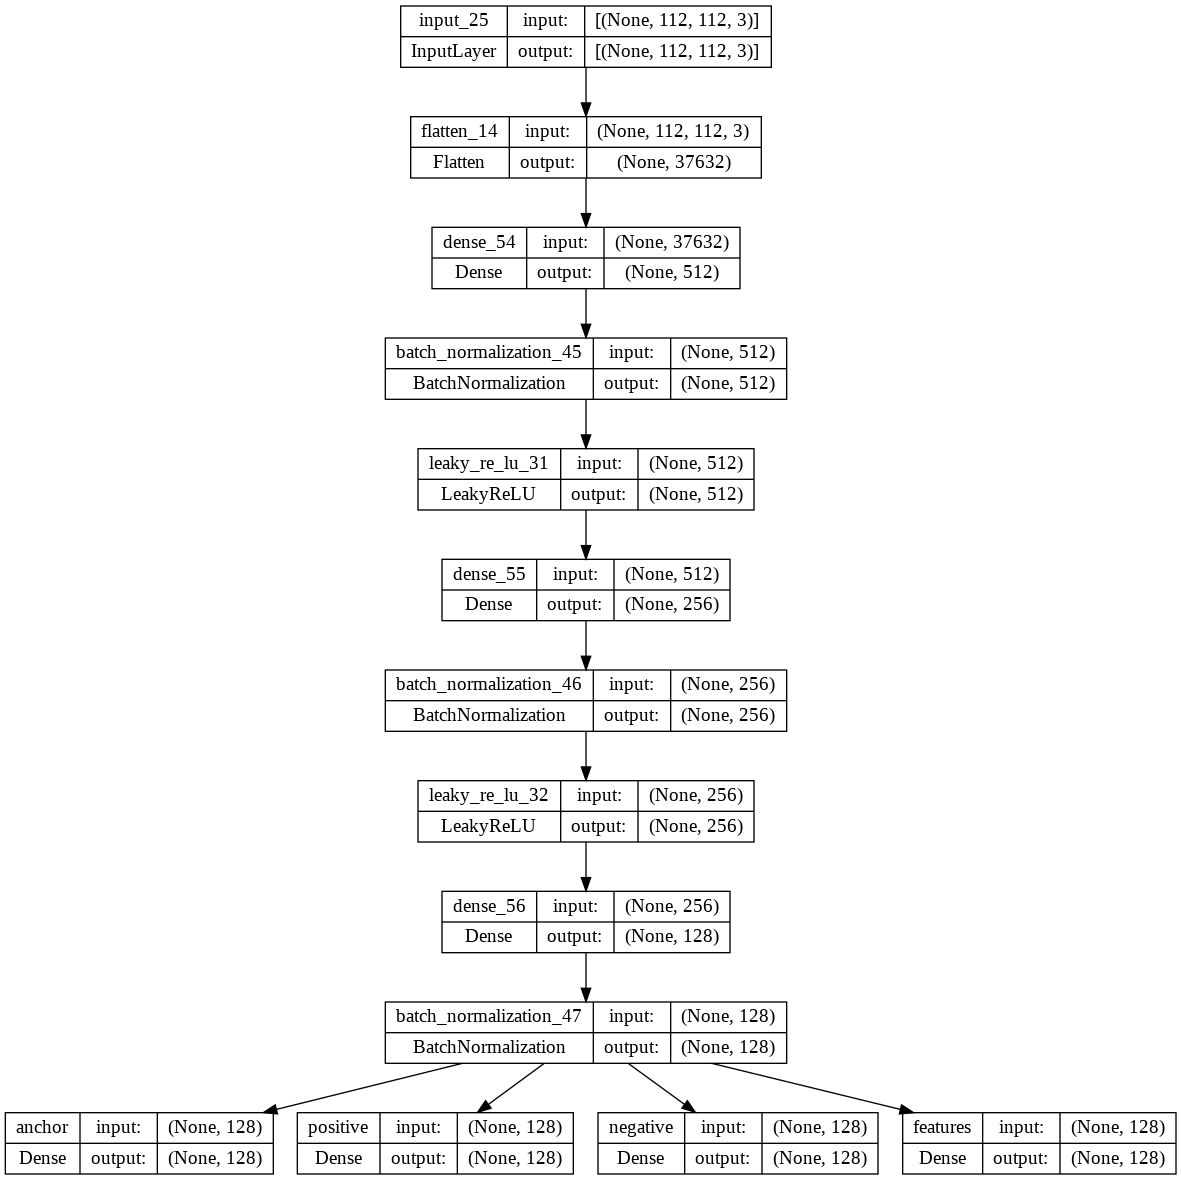


> Dica! Você pode criar este diagrama automaticamente utilizando o comando 
```
from keras.utils import plot_model
plot_model(metric_model, to_file='model.png', show_shapes= True)
```

Nós também estamos usando um passo de compilação com o otimizador 'adam' e uma função de *triplet loss*, que, como eu falei, é adequada para o aprendizado de métrica. O último passo é treinar o modelo no conjunto de dados de treinamento e validar o modelo no conjunto de dados de validação.



In [142]:
# Treinando o modelo
metric_model.fit(train_dataset, validation_data=validation_dataset, epochs=10, batch_size=32)

Epoch 1/10


313/313 [==============================] - 46s 144ms/step - loss: 32.5241 - anchor_loss: 32.5241 - val_loss: 4.7457 - val_anchor_loss: 4.7457
Epoch 2/10
313/313 [==============================] - 42s 135ms/step - loss: 3.4539 - anchor_loss: 3.4539 - val_loss: 9.3371 - val_anchor_loss: 9.3371
Epoch 3/10
313/313 [==============================] - 42s 135ms/step - loss: 2.8093 - anchor_loss: 2.8093 - val_loss: 3.2566 - val_anchor_loss: 3.2566
Epoch 4/10
313/313 [==============================] - 45s 144ms/step - loss: 2.4653 - anchor_loss: 2.4653 - val_loss: 1.8525 - val_anchor_loss: 1.8525
Epoch 5/10
313/313 [==============================] - 43s 136ms/step - loss: 1.7188 - anchor_loss: 1.7188 - val_loss: 1.1723 - val_anchor_loss: 1.1723
Epoch 6/10
313/313 [==============================] - 43s 137ms/step - loss: 1.7699 - anchor_loss: 1.7699 - val_loss: 1.4493 - val_anchor_loss: 1.4493
Epoch 7/10
313/313 [==============================] - 43s 136ms/step - loss: 1.8386 - anchor_loss: 1.83

> A abordagem geral parece sólida, mas tenha em mente que os seus futuros resultados dependerão de muitos fatores, como a qualidade dos dados, o tamanho do conjunto de dados, a escolha da função de perda e o ajuste de hiperparâmetros.

In [182]:
# Salvar o modelo em um arquivo HDF5
metric_model.save('metric_model.h5')

## Usando o modelo treinado

> **Atenção:** Você pode executar o comando abaixo se não quiser treinar o modelo do zero!

In [ ]:
!wget https://github.com/LuanMagioli/Machine-Learning/raw/main/Metric%20Learning/model/metric_model%20.h5

# Carregar o modelo a partir do arquivo HDF5
metric_model = keras.models.load_model('metric_model.h5', custom_objects={'triplet_loss': triplet_loss})

In [161]:
import pandas as pd

# Criando um dataframe com os vetores de características para cada pessoa
features = []
person_names = []

class_indices = train_dataset.class_indices
class_names = {v: k for k, v in class_indices.items()}


# Para cada batch
for images, labels in train_dataset:
    # Para cada imagem
    for i in range(len(images)):
        image = images[i]
        label = labels[i]
        label_string = class_names[np.argmax(label)]

        # Só queremos executar uma foto por pessoa
        if label_string not in person_names:
            # Obtendo o vetor de características para esta imagem
            feature_vector = metric_model.predict(np.expand_dims(image, 0), verbose= False)[-1][0]
            features.append(feature_vector)
            person_names.append(label_string)

    if(len(person_names) == len(class_names)):
      break

In [162]:
# Cria um DataFrame do Pandas com as características e as classes
df = pd.DataFrame({"features":  features})
df['name'] = person_names
df

,features,name
0,"[0.57962394, -0.6616598, -0.44054806, -0.31751...",Svetlana_Koroleva
1,"[0.583967, -0.31083918, -0.48663974, -0.565759...",Michael_Chiklis
2,"[0.8136645, -0.19436653, -0.6625457, -0.758768...",Melissa_Stark
3,"[1.7509173, 0.046356082, -1.2359502, -0.699091...",Tom_Glavine
4,"[-0.7918014, -0.4453957, 0.57728994, 0.7792564...",Anthony_LaPaglia
...,...,...
2991,"[-0.5108676, -0.12308337, 0.26796025, 0.268977...",Hermogenes_Ebdane_Jr
2992,"[0.37989393, 0.16375455, -0.28896895, -0.16683...",Ernie_Stewart
2993,"[0.40177763, -0.17344308, -0.27539763, -0.5210...",Jason_Priestley
2994,"[0.37217572, -0.20969334, -0.31342518, -0.6016...",Hernan_Crespo


> Dica: você pode salvar o dataframe usando o comando 
```
df.to_csv('features.csv', index=False)
``` 

### Adicionando novas pessoas

Como explicado anteriormente, uma das características do Metric Learning é a possibilidade de adicionar novas classes (pessoas no nosso caso) sem precisar treinar a rede novamente.

> Só lembrando pois nunca é demais: O objetivo do Metric Learning é ensinar a máquina a encontrar as características que melhor diferenciam as classes! Quem vai descobrir quem pertence a qual classe é uma função simples de distância entre os dados (por exemplo a euclidiana ou usando a vizinhança KNN).  

In [163]:
def extract_features(filename):
  # Carregando a imagem
  img = keras.preprocessing.image.load_img(filename, target_size=(112, 112))

  #Exibindo a imagem
  plt.imshow(img)
  plt.axis(False)

  #Preprocessamento da imagem
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img/255.

  # Executando o modelo e salvando a saída de características em uma variável
  feature_vector = metric_model.predict(np.expand_dims(image, 0), verbose=0)[3]
  return feature_vector.reshape(-1,)

,features,name
0,"[-0.73488164, 0.5251611, 0.9270905, 0.31076342...",Marcelo


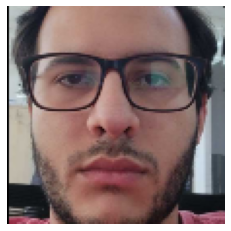

In [164]:
# Adicionando a nova pessoa ao banco de dados

new_row = pd.DataFrame({'features': [extract_features('person.png')], 'name': ["Marcelo"]})
df = df.append(new_row, ignore_index=True)

new_row

### Buscando a pessoa no banco de dados

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Criando o objeto KNN
knn = NearestNeighbors(n_neighbors=1)

# Treinando o modelo com as características do dataframe
knn.fit(np.stack(df["features"]))

# Encontrando o índice da linha (pessoa) mais próxima
mask_features = extract_features("person_mask.png")
distances, indices = knn.kneighbors([mask_features])

# Encontrando o nome da pessoa correspondente
min_index = indices[0][0]
person_name = df.iloc[min_index]["name"]

O código acima cria um objeto KNN (K Nearest Neighbors) e o treina com as características do dataframe. Logo após, extrai as características da máscara da pessoa que queremos identificar e aplica o modelo treinado para encontrar o índice da linha (pessoa) mais próxima. Por fim, é encontrado o nome da pessoa correspondente ao índice encontrado.

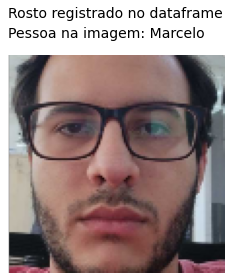

In [182]:
# Exibindo a imagem
img = plt.imread("person.png")
plt.imshow(img)

# Adicionando o texto do resultado sobre a imagem
plt.text(0, -20, "Rosto registrado no dataframe", fontsize=14)
plt.text(0, -10, "Pessoa na imagem: "+ person_name, fontsize=14)
plt.axis('off')
plt.show()